#  <center> Counterfactual analysis tutorial <center>
<center> Spring 2023 <center>
<center> 3.C01/3.C51, 10.C01/10.C51, 20.C01/20.C51 <center>
<center> No deadline, not graded <center>

In [1]:
# install exmol and rdkit
! pip install exmol
! pip install rdkit

     |████████████████████████████████| 4.7 MB 3.9 MB/s eta 0:00:01
     |████████████████████████████████| 2.6 MB 21.7 MB/s eta 0:00:01
  Using cached ratelimit-2.2.1.tar.gz (5.3 kB)
  Created wheel for ratelimit: filename=ratelimit-2.2.1-py3-none-any.whl size=5908 sha256=866e09117172f750b76588502bdb396724c0ea3deed77f96be1ccd89cc040507
  Stored in directory: /Users/crystal/Library/Caches/pip/wheels/14/1e/97/126009a0884bdf7e26436cace73d9a4f4596dada4fdc4950ce
Successfully built ratelimit


In [2]:
# import libraries

from tqdm import tqdm
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import shuffle

## 1.1 Load the dataset

Download the BioAssay Classification Evaluation (BACE) dataset, which contains SMILES strings and corresponding labels indicating whether the molecule is active (1) or inactive (0). The BACE dataset is a publicly available dataset that was created to evaluate the performance of models for predicting the activity of human $\beta$-secretase 1 inhibitors (BACE-1). $\beta$-secretase is an enzyme that plays a key role in the formation of amyloid peptides in neural tissue, which are a hallmark of Alzheimer's disease. The dataset originally contains 1,513 molecules, but we removed samples with very long SMILES strings ($>100$) to obtain a dataset of 1,482 molecules. 

In [3]:
# Downloading BACE dataset
# BACE dataset is a dataset for predicting the inhibition of BACE1, which is a target for Alzheimer's disease. 
# The dataset is downloaded from
! wget https://raw.githubusercontent.com/SoojungYang/ML4MolEng_Spring2023/main/BACE_clean.csv

--2023-05-06 16:12:39--  https://raw.githubusercontent.com/SoojungYang/ML4MolEng_Spring2023/main/BACE_clean.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98109 (96K) [text/plain]
Saving to: ‘BACE_clean.csv’

BACE_clean.csv      100%[===================>]  95.81K  --.-KB/s    in 0.03s   

2023-05-06 16:12:40 (3.52 MB/s) - ‘BACE_clean.csv’ saved [98109/98109]



In [4]:
# Character list for SMILES string
moses_charset = ['2', 'o', 'C', 'I', 'O', 'H', 'n', 'N', '=', '+', '#', '-', 'c',
                 'B', 'l', '7', 'r', 'S', 's', '4', '6', '[', '5', ']', 'F', '3', 
                 'P', '(', ')', '1', ' ']

# Load the encoder 
enc = preprocessing.LabelEncoder().fit(moses_charset)

# Read data 
df = pd.read_csv("./BACE_clean.csv", index_col=0)
df = shuffle(df).reset_index()

After loading the dataset, pad the SMILES strings and transform them using the One Hot encoder.

In [47]:
# Process the data
max_len = 0 
for smiles in df.smiles:
  if len(smiles) > max_len: 
    max_len = len(smiles)

X, label_list = [], []
for i, row in df.iterrows():  
    pad_smiles = list( row.smiles.ljust(max_len) )
    smiles_code = enc.transform(pad_smiles)
    X.append(smiles_code)
    label_list.append(row.label)

As usual, split our data into training, validation, and test sets, with proportions of 70\%, 10\%, and 20\%, respectively. 

In [48]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, label_list, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2/0.8)

## 1.2 Train your own classifier

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

# Define the random forest classifier and HistGradientBoostingClassifier
# Random forest classifier is a classifier that uses multiple decision trees to predict the label of a sample.
# HistGradientBoostingClassifier is a classifier that uses gradient boosting on histograms to predict the label of a sample.
# You can try other classifiers, such as SVM, MLP, etc.

clf = RandomForestClassifier(max_depth=8, random_state=0)
clf = HistGradientBoostingClassifier(random_state=0)
clf.fit(X_train, y_train)
predicted = clf.predict(X_test)

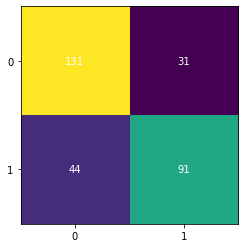

In [50]:
# plot confusion matrix of the test set
conf_mat = confusion_matrix(y_test, predicted)

fig, ax = plt.subplots()
im = ax.imshow(conf_mat)

ax.set_xticks(np.arange(2))
ax.set_yticks(np.arange(2))

ax.set_xticklabels([0, 1])
ax.set_yticklabels([0, 1])

# Loop over data dimensions and create text annotations.
for i in range(2):
    for j in range(2):
        text = ax.text(j, i, conf_mat[i, j],
                       ha="center", va="center", color="w")


plt.show()

In [51]:
# Print accuracy of the classifier
acc = (np.array(predicted)==np.array(y_test)).sum()/len(predicted)
print("accuracy {:.3f}".format(acc))

accuracy 0.747


## 1.3 Explain the model predictions using exmol package

Finally, use an explainer called exmol to explain your model's predictions using counterfactual analysis. Counterfactual analysis is a technique used in machine learning to explain the decisions made by a model. It involves generating "counterfactual" examples - that is, examples that are similar to a given input, but with some differences that result in a different output from the model. These counterfactual examples can be used to gain insight into how the model is making its predictions, and to identify which features of the input are most important for the model's decision.  

Counterfactual analysis can be used to explain the predictions of a classifier by generating examples that are similar to a given input but have a different class label. For example, if a model predicts that a molecule is active against beta-secretase, counterfactual analysis can be used to generate similar molecules that are predicted to be inactive, and vice versa. By examining the differences between the original molecule and its counterfactuals, we can gain insight into which features of the molecule are most important for the model's prediction.  

The exmol package provides several functions for generating counterfactual examples and visualizing the results. Use exmol functions, such as cf_explain, which  function generates counterfactual examples using a variant of the LIME algorithm, lime_explain, generates counterfactual examples using the LIME algorithm, and plot_descriptors, which can be used to visualize the differences between the original molecule and its counterfactuals in terms of their molecular descriptors. 

For more information, read the exmol documentation and tutorial, which is available at https://ur-whitelab.github.io/exmol/paper2_LIME/Tutorial.html. 

In [10]:
import exmol
import skunk # skunk is a library that allows you to create interactive widgets

In [41]:
# exmol takes a SMILES string as input, so we will need to convert the character indices back to SMILES
# We can use the function index2smiles() to do this
def index2smiles(mol_index, enc):
    '''Transform your array of character indices back to SMILES'''
    smiles_charlist = enc.inverse_transform(np.array(mol_index))
    smiles = ''.join(smiles_charlist).strip(" ")
    return smiles


# model_eval() takes a SMILES string as input and returns the predicted label of the SMILES string
# It is a wrapper function to make the input and output compatible with exmol
def model_eval(smiles):
    '''Predict the label of a SMILES string'''
    try:
        pad_smiles = list(smiles.ljust(max_len))
        x_code = enc.transform(pad_smiles)
        pred = clf.predict([x_code])
    except:
        pred = [None]
    return pred[0]

In [52]:
# randomly select a molecule from test_loader
idx = 1
x = index2smiles(X_test[idx], enc)
y = y_test[idx]
print('smiles: ', x)
print('y true: ', y)
print('y pred: ', model_eval(x))
# ground truth label and the predicted label are the same, allowing us to use the molecule as an example

smiles:  FC(F)(F)c1cc(ccc1)C[NH2+]CC(O)C(NC(=O)c1cc(N2CCCC2=O)c2occ(c2c1)CC)Cc1ccccc1
y true:  1
y pred:  1


In [53]:
# create exmol space
space = exmol.sample_space(x, model_eval, batched=False, preset='narrow')

















































🤘Done🤘: 100%|██████████| 2554.0/2554 [00:22<00:00, 115.77it/s] 


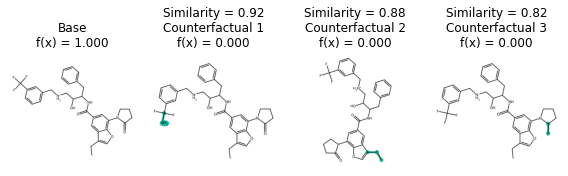

In [54]:
# exmol.cf_explain() returns a list of explanations
# Counterfactual 1, 2, 3 are the top 3 explanations in terms of Similarity
# Highlighted atoms are the atoms that are changed in the counterfactuals
# Which implies that these atoms are important for the prediction

exps = exmol.cf_explain(space)
fkw = {"figsize": (8, 6)}
mpl.rc("axes", titlesize=12)
exmol.plot_cf(exps, figure_kwargs=fkw, mol_size=(450, 400), nrows=1)

LIME (Local Interpretable Model-Agnostic Explanations) is a technique used in machine learning to explain the predictions made by a model. It works by generating "local" explanations for individual predictions - that is, explanations that apply only to a single instance of input data, rather than to the model as a whole. To generate these local explanations, LIME creates "perturbations" of the original input data by randomly adding or removing features. It then trains a new model (known as an "interpretable model") on these perturbed data points, and uses this model to explain the original prediction. The interpretable model is typically a simple model such as a linear regression or decision tree, which can be easily understood and visualized.  

😀Calling your model function😀: 100%|██████████| 3000/3000 [08:32<00:00,  5.86it/s] 


SMARTS annotations for MACCS descriptors were created using SMARTSviewer (smartsview.zbh.uni-hamburg.de, Copyright: ZBH, Center for Bioinformatics Hamburg) developed by K. Schomburg et. al. (J. Chem. Inf. Model. 2010, 50, 9, 1529–1535)


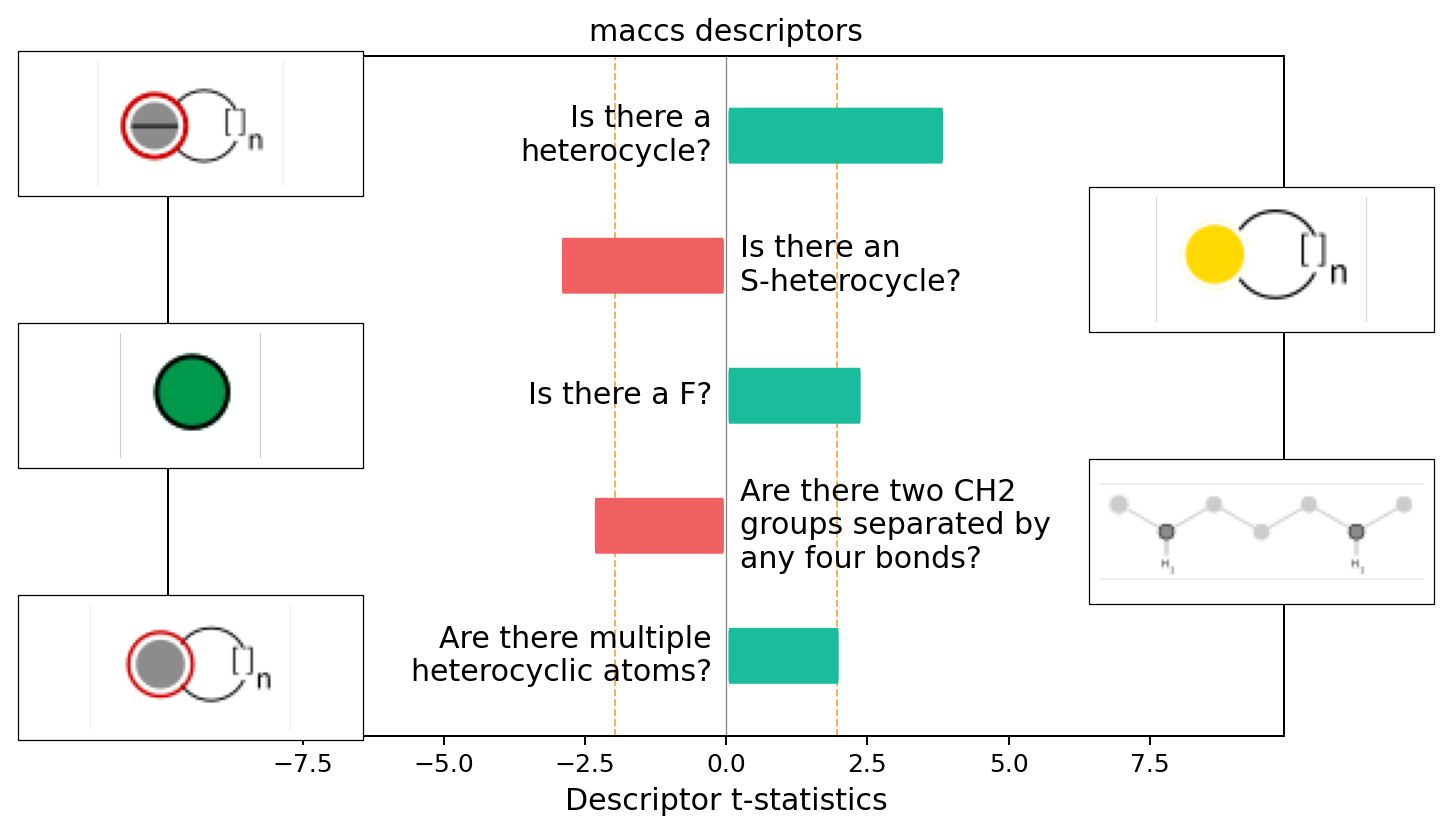

In [58]:
exmol.lime_explain(space)
exmol.plot_descriptors(space)

In [59]:
exmol.lime_explain(space, descriptor_type="ECFP")
svg = exmol.plot_descriptors(space, return_svg=True)
skunk.display(svg)
svg = exmol.plot_utils.similarity_map_using_tstats(space[0], return_svg=True)
skunk.display(svg)

text_explain provides us with the natural language description of the model prediction. 

In [60]:
exmol.lime_explain(space, descriptor_type="ECFP")
e = exmol.text_explain(space)
for ei in e:
    print(ei[0], end="")

Is there heterocyclic/alkane group? Yes and this is positively correlated with property. This is important for the property
Is there lactam? Yes and this is positively correlated with property. This is important for the property
Is there ammonium/secondary amide/secondary alcohol/aromatic group? Yes and this is positively correlated with property. This is important for the property
